importing libraries

In [2]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

Creating the custom frozen lake class 

Last week i created custom environment of my own using a custom map. This time i improved it with the following features - 

It generates a grid-based map and to ensure that the environment is solvable, the class uses a random walk to carve out at least one valid path from the start to the goal, and then populates the rest of the grid with holes based on a specified probability. The environment validates this path using a breadth-first search algorithm to confirm reachability. The agent's movement is controlled via the step method, which handles transitions based on the action taken (left, down, right, up), applies reward shaping to encourage progress toward the goal, and penalizes falling into holes.

When the agent falls into a hole ('H'), it receives a negative reward of -1, immediately ending the episode—this penalizes unsafe exploration. Reaching the goal ('G') yields a high positive reward of +10, reinforcing successful trajectories. For every other step on safe tiles ('F'), the agent receives a shaped reward composed of a small base penalty of -0.01 (to discourage wandering) and a positive proximity bonus that scales inversely with the Manhattan distance to the goal (0.05 * (1 / (dist_to_goal + 1))). This reward shaping encourages the agent to move efficiently toward the goal, even when it's far away, providing continuous feedback rather than sparse signals.

In [ ]:
class FrozenLake:
    def __init__(self, size=100, hole_prob=0.2):
        self.size = size
        self.hole_prob = hole_prob
        self.map = None
        self.goal = (size - 1, size - 1)
        self.generate_valid_map()
        print(f"Generated valid map with {self.count_holes()} holes")

    def count_holes(self):
        return sum(row.count('H') for row in self.map)

    def generate_valid_map(self):
        #Generates a map with guaranteed path using randomized BFS
        while True:
            grid = [['F'] * self.size for _ in range(self.size)]
            grid[0][0] = 'S'
            grid[self.size-1][self.size-1] = 'G'
            
            # Create safe corridors from start to goal
            path_cells = set()
            r, c = 0, 0
            while (r, c) != self.goal:
                if random.random() < 0.5 and r < self.size-1:
                    r += 1
                elif c < self.size-1:
                    c += 1
                path_cells.add((r, c))
            
            # Add holes with path protection
            for r in range(self.size):
                for c in range(self.size):
                    if (r, c) in [(0, 0), self.goal]:
                        continue
                    if (r, c) not in path_cells and random.random() < self.hole_prob:
                        grid[r][c] = 'H'
            
            if self.has_path(grid):
                self.map = grid
                return

    def has_path(self, grid):
        #BFS path verification with early stopping
        visited = [[False] * self.size for _ in range(self.size)]
        queue = deque([(0, 0)])
        visited[0][0] = True
        
        while queue:
            r, c = queue.popleft()
            if (r, c) == self.goal:
                return True
                
            for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < self.size and 0 <= nc < self.size:
                    if not visited[nr][nc] and grid[nr][nc] != 'H':
                        visited[nr][nc] = True
                        queue.append((nr, nc))
        return False

    def reset(self):
        self.state = (0, 0)
        return self.state
        
    def step(self, action):
        r, c = self.state
        if action == 0: c = max(0, c-1)
        elif action == 1: r = min(self.size-1, r+1)
        elif action == 2: c = min(self.size-1, c+1)
        elif action == 3: r = max(0, r-1)
            
        self.state = (r, c)
        cell = self.map[r][c]
        
        
        dist_to_goal = abs(r - (self.size-1)) + abs(c - (self.size-1))
        
        if cell == 'H':
            return self.state, -1, True
        elif cell == 'G':
            return self.state, 10, True
            
        # Reward shaping
        base_reward = -0.01
        progress_bonus = 0.05 * (1 / (dist_to_goal + 1))
        return self.state, base_reward + progress_bonus, False

    def get_state_index(self, state):
        return state[0] * self.size + state[1]


Monte Carlo - 

Upon initialization, it sets up a Q-table with optimistic values to encourage exploration and tracks visit counts for each state-action pair. It supports two exploration strategies: epsilon-greedy and Boltzmann exploration(Though i have only evaluated Boltzmann), with an optional goal biasing mechanism that nudges the agent toward moving right or down during early episodes. The core training routine, defined in the train method, runs for a specified number of episodes, where in each episode, the agent interacts with the environment, stores the sequence of visited states, actions, and rewards, and then uses that complete trajectory to compute returns and update Q-values. It supports both first-visit and every-visit Monte Carlo updates, and employs an adaptive learning rate that decays with visit count. The agent also collects and stores performance metrics throughout training, such as success rate, average reward, and steps to goal, which are recorded at regular intervals. Additional utility methods provide access to the learned policy, state-value function, full Q-table, and logged metrics.

In [ ]:
class MonteCarloAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.05, discount_factor=0.98,
                 exploration_strategy='boltzmann'):
        """
        Args:
            state_size (int): Number of states in environment
            action_size (int): Number of actions available
            learning_rate (float): Initial learning rate (alpha)
            discount_factor (float): Discount factor for future rewards (gamma)
            exploration_strategy (str): Exploration strategy ('epsilon_greedy' or 'boltzmann')
            # The boltzmann strategy turns out to be more effective than the 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_strategy = exploration_strategy
        
        
        initial_q = 1.0
        self.Q = np.ones((state_size, action_size)) * initial_q
        
        # Initialize visit counts
        self.returns_count = np.zeros((state_size, action_size))
        
        # State visitation tracker
        self.state_visit_count = np.zeros(state_size)
        
        # Training metrics
        self.metrics = {
            'episodes': [],
            'success_rate': [],
            'avg_reward': [],
            'epsilon': [],
            'steps_to_goal': [],
            'q_values': []
        }

    def select_action(self, state_idx, epsilon, goal_bias=0.0, env_size=None):
        """
        Select an action using the current policy with exploration
        
        Args:
            state_idx (int): Current state index
            epsilon (float): Exploration rate
            goal_bias (float): Probability to bias action toward goal
            env_size (int): Size of environment (needed for goal biasing)
            
        Returns:
            int: Selected action
        """
        # State-dependent epsilon: less exploration in frequently visited states
        state_epsilon = epsilon * (1 / (1 + self.state_visit_count[state_idx] / 100))
        
        # Goal-biased action selection (This part of goal based optimisation was attained with help of 'Deepseek')
        if random.random() < goal_bias and env_size is not None:
            # Prefer actions moving toward goal (right and down)
            if random.random() < 0.5 and state_idx % env_size < env_size - 1:
                return 2  # Right
            elif state_idx // env_size < env_size - 1:
                return 1  # Down
            else:
                return random.randint(0, self.action_size-1)
        
        # Epsilon-greedy exploration
        if self.exploration_strategy == 'epsilon_greedy':
            if random.random() < state_epsilon:
                return random.randint(0, self.action_size-1)
            else:
                # Exploitation with tie-breaking
                best_actions = np.argwhere(self.Q[state_idx] == np.max(self.Q[state_idx])).flatten()
                return int(np.random.choice(best_actions))
        
        # Boltzmann exploration
        elif self.exploration_strategy == 'boltzmann':
            probabilities = np.exp(self.Q[state_idx] / max(epsilon, 1e-5))
            probabilities /= np.sum(probabilities)
            return np.random.choice(range(self.action_size), p=probabilities)
        
        return random.randint(0, self.action_size-1)

    def train(self, env, episodes=20000, max_steps=3000, 
              epsilon_start=1.0, epsilon_min=0.1, 
              decay_rate=0.0001, alpha_decay=0.00005,
              use_first_visit=True):
        """
        Train the agent using Monte Carlo control
        
        Args:
            env: FrozenLake environment instance
            episodes (int): Number of training episodes
            max_steps (int): Maximum steps per episode
            epsilon_start (float): Starting exploration rate
            epsilon_min (float): Minimum exploration rate
            decay_rate (float): Epsilon decay rate
            alpha_decay (float): Learning rate decay factor
            use_first_visit (bool): Whether to use first-visit MC
        """
        self.env = env
        self.env_size = env.size
        
        # Reset metrics
        self.metrics = {
            'episodes': [],
            'success_rate': [],
            'avg_reward': [],
            'epsilon': [],
            'steps_to_goal': [],
            'q_values': []
        }
        
        success_history = deque(maxlen=1000)
        reward_history = deque(maxlen=1000)
        step_history = deque(maxlen=1000)
        
        start_time = time.time()
        
        # Precompute epsilons
        epsilons = np.maximum(epsilon_min, epsilon_start * np.exp(-decay_rate * np.arange(episodes)))
        
        # Reset visit counts
        self.state_visit_count = np.zeros(self.state_size)
        self.returns_count = np.zeros((self.state_size, self.action_size))
        
        for ep in tqdm(range(episodes), desc="Training MC"):
            state = env.reset()
            state_idx = env.get_state_index(state)
            epsilon = epsilons[ep]
            
            # Generate an episode
            episode = []
            done = False
            total_reward = 0
            steps = 0
            success = False
            
            # Goal-biased exploration parameter
            goal_bias = 0.3 * (1 - (ep / episodes))  # Decreases over time
            
            for step in range(max_steps):
                action = self.select_action(state_idx, epsilon, goal_bias, self.env_size)
                next_state, reward, done = env.step(action)
                next_state_idx = env.get_state_index(next_state)
                
                # Track state visits
                self.state_visit_count[state_idx] += 1
                
                # Record the experience
                episode.append((state_idx, action, reward))
                total_reward += reward
                steps += 1
                
                # Move to next state
                state_idx = next_state_idx
                
                if done:
                    if reward > 1:  # Goal reached
                        success = True
                    break

            # Update metrics
            success_history.append(success)
            reward_history.append(total_reward)
            step_history.append(steps if success else max_steps)
            
            # Process the episode for MC updates
            G = 0
            
            # Track visited state-actions for first-visit
            episode_visited = set()
            
            # Traverse the episode in reverse order
            for t in range(len(episode)-1, -1, -1):
                state_idx, action, reward = episode[t]
                G = self.discount_factor * G + reward
                
                # Update condition for first-visit or every-visit
                state_action = (state_idx, action)
                update_condition = True
                
                if use_first_visit:
                    if state_action in episode_visited:
                        update_condition = False
                    else:
                        episode_visited.add(state_action)
                
                if update_condition:
                    # Adaptive learning rate
                    self.returns_count[state_idx, action] += 1
                    alpha_curr = self.learning_rate / (1 + alpha_decay * self.returns_count[state_idx, action])
                    
                    # Update Q-value
                    td_error = G - self.Q[state_idx, action]
                    self.Q[state_idx, action] += alpha_curr * td_error
            
            # Record every 1000 episodes
            if ep % 1000 == 0 or success:
                success_rate = np.mean(success_history) if success_history else 0
                avg_reward = np.mean(reward_history) if reward_history else 0
                avg_steps = np.mean(step_history) if step_history else max_steps
                
                self.metrics['episodes'].append(ep)
                self.metrics['success_rate'].append(success_rate)
                self.metrics['avg_reward'].append(avg_reward)
                self.metrics['epsilon'].append(epsilon)
                self.metrics['steps_to_goal'].append(avg_steps)
                
                # Sample Q-values for visualization
                sample_states = [0, self.env_size//2, self.env_size**2 - 1]
                self.metrics['q_values'].append(
                    [self.Q[s, :].copy() for s in sample_states]
                )
                
                if ep % 5000 == 0:
                    print(f"MC Ep {ep}: SR={success_rate:.2%}, ε={epsilon:.4f}, "
                          f"Steps={avg_steps:.1f}, R={avg_reward:.3f} {'(Success)' if success else ''}")

        training_time = time.time() - start_time
        print(f"Monte Carlo Training completed in {training_time/60:.2f} minutes")
        return self.metrics

    def get_policy(self):
        """Get the current greedy policy"""
        return np.argmax(self.Q, axis=1)
    
    def get_value_function(self):
        """Get the current state value function"""
        return np.max(self.Q, axis=1)
    
    def get_action(self, state_idx, epsilon=0.0):
        """
        Get action using current policy
        
        Args:
            state_idx (int): Current state index
            epsilon (float): Exploration rate (0 for pure exploitation)
            
        Returns:
            int: Selected action
        """
        if random.random() < epsilon:
            return random.randint(0, self.action_size-1)
        return np.argmax(self.Q[state_idx])
    
    def get_q_values(self):
        """Get the full Q-table"""
        return self.Q.copy()
    
    def get_metrics(self):
        """Get training metrics"""
        return self.metrics.copy()

Q-Learning -

The agent maintains a Q-table initialized with small random values to encourage early exploration, and it updates this table using the Bellman equation after each step, combining immediate rewards with the estimated future value of the best possible next action. It supports both epsilon-greedy and Boltzmann exploration strategies to balance exploration and exploitation during learning. The training function sets up the agent and runs it through a specified number of episodes, progressively decaying both the exploration rate (epsilon) and the learning rate to fine-tune the policy over time. During each episode, the agent collects rewards, tracks whether it successfully reaches the goal, and logs performance metrics such as success rate, average rewards, and steps taken. These metrics are recorded periodically to monitor learning progress, and the function returns both the trained agent and the collected training data.

In [ ]:
class QLearningAgent:
    def __init__(self, state_size, action_size, 
                 learning_rate=0.8, discount_factor=0.95,
                 exploration_strategy='epsilon_greedy'):
        # Optimistic initialization
        self.q_table = np.random.uniform(low=0, high=0.1, size=(state_size, action_size))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_strategy = exploration_strategy
        self.state_size = state_size
        self.action_size = action_size
        
    def update(self, state, action, reward, next_state, done, learning_rate):
        current_q = self.q_table[state, action]
        if done:
            target_q = reward
        else:
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.discount_factor * max_next_q
            
        self.q_table[state, action] += learning_rate * (target_q - current_q)
        
    def get_action(self, state, epsilon):
        if self.exploration_strategy == 'epsilon_greedy':
            if random.random() < epsilon:
                return random.randint(0, self.action_size - 1)
            return np.argmax(self.q_table[state])
        
        elif self.exploration_strategy == 'boltzmann':
            probabilities = np.exp(self.q_table[state] / max(epsilon, 1e-5))
            probabilities /= np.sum(probabilities)
            return np.random.choice(range(self.action_size), p=probabilities)
            
    def get_policy(self):
        return np.argmax(self.q_table, axis=1)
    
    def get_value_function(self):
        return np.max(self.q_table, axis=1)

def train_q_learning(env, episodes=100000, max_steps=3000,
                epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.99995,
                learning_rate_start=0.8, learning_rate_end=0.1):
    state_size = env.size * env.size
    action_size = 4
    agent = QLearningAgent(state_size, action_size,
                          learning_rate=learning_rate_start,
                          discount_factor=0.95,
                          exploration_strategy='epsilon_greedy')
    
    epsilon = epsilon_start
    learning_rate = learning_rate_start
    decay_factor = (learning_rate_end / learning_rate_start) ** (1/episodes)
    
    metrics = {
        'episodes': [],
        'success_rate': [],
        'avg_reward': [],
        'epsilon': [],
        'learning_rate': [],
        'steps_to_goal': []
    }
    
    success_history = deque(maxlen=1000)
    reward_history = deque(maxlen=1000)
    step_history = deque(maxlen=1000)
    
    start_time = time.time()
    
    for episode in tqdm(range(episodes), desc="Training QL"):
        state = env.reset()
        state_idx = env.get_state_index(state)
        total_reward = 0
        done = False
        steps = 0
        success = False

        for step in range(max_steps):
            action = agent.get_action(state_idx, epsilon)
            next_state, reward, done = env.step(action)
            next_state_idx = env.get_state_index(next_state)
            
            agent.update(state_idx, action, reward, next_state_idx, done, learning_rate)
            
            state_idx = next_state_idx
            total_reward += reward
            steps += 1
            
            if done:
                if reward > 1:  # Goal reached
                    success = True
                break

        # Update metrics
        success_history.append(success)
        reward_history.append(total_reward)
        step_history.append(steps if success else max_steps)
        
        # Decay exploration and learning rate
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        learning_rate = max(learning_rate_end, learning_rate * decay_factor)
        
        # Record every 500 episodes
        if episode % 500 == 0:
            success_rate = np.mean(success_history) if success_history else 0
            avg_reward = np.mean(reward_history) if reward_history else 0
            avg_steps = np.mean(step_history) if step_history else 0
            
            metrics['episodes'].append(episode)
            metrics['success_rate'].append(success_rate)
            metrics['avg_reward'].append(avg_reward)
            metrics['epsilon'].append(epsilon)
            metrics['learning_rate'].append(learning_rate)
            metrics['steps_to_goal'].append(avg_steps)
            
            if episode % 10000 == 0:
                print(f"QL Ep {episode}: SR={success_rate:.2%}, ε={epsilon:.4f}, "
                      f"LR={learning_rate:.4f}, Steps={avg_steps:.1f}, R={avg_reward:.3f}")

    training_time = time.time() - start_time
    print(f"Q-Learning Training completed in {training_time/60:.2f} minutes")
    return metrics, agent

Sarsa - 

This function implements the SARSA (State-Action-Reward-State-Action) algorithm for on-policy reinforcement learning. It begins by optimistically initializing a Q-table to encourage early exploration and precomputes a schedule for decaying epsilon values to reduce exploration over time. For each training episode, the agent selects an initial action based on an epsilon-greedy policy, then interacts with the environment, taking actions and updating the Q-values using the SARSA update rule, which incorporates the value of the next chosen action rather than the maximum possible future value (as in Q-learning). This approach ensures the updates are aligned with the agent's actual behavior policy. The learning rate is also decayed over time to stabilize learning. Throughout training, performance metrics like success rate, average reward, and steps to reach the goal are recorded. After training, a lightweight SARSAWrapper class is returned alongside the metrics, providing access to the learned policy, value function, and action selection, mimicking the interface of other agent classes for uniform evaluation and comparison.

In [6]:
def train_sarsa(env, episodes=100000, max_steps=3000, 
                alpha=0.2, discount=0.95,
                epsilon_start=1.0, epsilon_min=0.01,
                decay_rate=0.0005,
                alpha_decay=0.0001):
    state_size = env.size * env.size
    action_size = 4
    
    # Optimistic initialization
    Q = np.ones((state_size, action_size)) * 5.0
    
    metrics = {
        'episodes': [],
        'success_rate': [],
        'avg_reward': [],
        'epsilon': [],
        'learning_rate': [],
        'steps_to_goal': []
    }
    
    success_history = deque(maxlen=1000)
    reward_history = deque(maxlen=1000)
    step_history = deque(maxlen=1000)
    
    start_time = time.time()
    
    # Precompute epsilons
    epsilons = np.maximum(epsilon_min, epsilon_start * np.exp(-decay_rate * np.arange(episodes)))
    
    for ep in tqdm(range(episodes), desc="Training SARSA"):
        state = env.reset()
        state_idx = env.get_state_index(state)
        epsilon = epsilons[ep]
        
        # Choose initial action
        if random.random() < epsilon:
            action = random.randint(0, action_size-1)
        else:
            best_actions = np.argwhere(Q[state_idx] == np.max(Q[state_idx])).flatten()
            action = int(np.random.choice(best_actions))
        
        # Learning rate decay
        alpha_curr = alpha / (1 + (alpha_decay * ep))
        
        total_reward = 0
        done = False
        steps = 0
        success = False

        for step in range(max_steps):
            next_state, reward, done = env.step(action)
            next_state_idx = env.get_state_index(next_state)
            total_reward += reward
            
            # Choose next action
            if random.random() < epsilon:
                next_action = random.randint(0, action_size-1)
            else:
                best_actions = np.argwhere(Q[next_state_idx] == np.max(Q[next_state_idx])).flatten()
                next_action = int(np.random.choice(best_actions))
            
            # SARSA update
            if not done:
                td_target = reward + discount * Q[next_state_idx, next_action]
            else:
                td_target = reward
                
            td_error = td_target - Q[state_idx, action]
            Q[state_idx, action] += alpha_curr * td_error
            
            # Move to next state
            state_idx = next_state_idx
            action = next_action
            steps += 1
            
            if done:
                if reward > 1:  # Goal reached
                    success = True
                break

        # Update metrics
        success_history.append(success)
        reward_history.append(total_reward)
        step_history.append(steps if success else max_steps)
        
        # Record every 500 episodes
        if ep % 500 == 0:
            success_rate = np.mean(success_history) if success_history else 0
            avg_reward = np.mean(reward_history) if reward_history else 0
            avg_steps = np.mean(step_history) if step_history else 0
            
            metrics['episodes'].append(ep)
            metrics['success_rate'].append(success_rate)
            metrics['avg_reward'].append(avg_reward)
            metrics['epsilon'].append(epsilon)
            metrics['learning_rate'].append(alpha_curr)
            metrics['steps_to_goal'].append(avg_steps)
            
            if ep % 20000 == 0:
                print(f"SARSA Ep {ep}: SR={success_rate:.2%}, ε={epsilon:.4f}, "
                      f"LR={alpha_curr:.4f}, Steps={avg_steps:.1f}, R={avg_reward:.3f}")

    training_time = time.time() - start_time
    print(f"SARSA Training completed in {training_time/60:.2f} minutes")
    
    # Create agent-like interface
    class SARSAWrapper:
        def __init__(self, Q_table):
            self.q_table = Q_table
            
        def get_policy(self):
            return np.argmax(self.q_table, axis=1)
        
        def get_value_function(self):
            return np.max(self.q_table, axis=1)
        
        def get_action(self, state, _):
            return np.argmax(self.q_table[state])
    
    return metrics, SARSAWrapper(Q)

Running all the 3 algorithms for the env -

In [24]:
def evaluate_agent(env, agent, episodes=10000, max_steps=3000):
    successes = 0
    steps_list = []
    total_rewards = []
    
    for _ in range(episodes):
        state = env.reset()
        state_idx = env.get_state_index(state)
        done = False
        steps = 0
        episode_reward = 0
        
        for step in range(max_steps):
            action = agent.get_action(state_idx, 0)  # Greedy policy
            next_state, reward, done = env.step(action)
            state_idx = env.get_state_index(next_state)
            steps += 1
            episode_reward += reward
            
            if done:
                if reward > 1:  # Goal reached
                    successes += 1
                    steps_list.append(steps)
                break
        else:
            steps_list.append(max_steps)
        total_rewards.append(episode_reward)
                
    success_rate = successes / episodes
    avg_steps = np.mean(steps_list) if steps_list else max_steps
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_steps, avg_reward

# Environment setup
size = 64
hole_prob = 0.2
env = FrozenLake(size=size, hole_prob=hole_prob)
state_size = env.size * env.size
action_size = 4


mc_episodes = 10000 #Running MC for less number of episodes
ql_episodes = 100000
sarsa_episodes = 100000

print("\n=== Training Monte Carlo ===")
# Create and train Monte Carlo agent
mc_agent = MonteCarloAgent(state_size, action_size)
mc_metrics = mc_agent.train(
    env,
    episodes=mc_episodes,
    epsilon_start=1.0,
    epsilon_min=0.1,
    decay_rate=0.0001
)

print("\n=== Training Q-Learning ===")
ql_metrics, ql_agent = train_q_learning(env, episodes=ql_episodes)

print("\n=== Training SARSA ===")
sarsa_metrics, sarsa_agent = train_sarsa(env, episodes=sarsa_episodes)

eval_episodes = 10000

print("\nEvaluating Monte Carlo Agent...")
mc_success, mc_steps, mc_reward = evaluate_agent(env, mc_agent, episodes=eval_episodes)

print("\nEvaluating Q-Learning Agent...")
ql_success, ql_steps, ql_reward = evaluate_agent(env, ql_agent, episodes=eval_episodes)

print("\nEvaluating SARSA Agent...")
sarsa_success, sarsa_steps, sarsa_reward = evaluate_agent(env, sarsa_agent, episodes=eval_episodes)

Generated valid map with 818 holes

=== Training Monte Carlo ===


Training MC:   5%|▍         | 480/10000 [00:00<00:01, 4763.05it/s]

MC Ep 0: SR=0.00%, ε=1.0000, Steps=3000.0, R=-1.058 


Training MC:  51%|█████▏    | 5130/10000 [00:03<00:04, 1152.28it/s]

MC Ep 5000: SR=0.00%, ε=0.6065, Steps=3000.0, R=-1.708 


Training MC: 100%|██████████| 10000/10000 [02:35<00:00, 64.26it/s] 


Monte Carlo Training completed in 2.59 minutes

=== Training Q-Learning ===


Training QL:   5%|▌         | 5179/100000 [00:00<00:04, 22757.33it/s]

QL Ep 0: SR=0.00%, ε=1.0000, LR=0.8000, Steps=3000.0, R=-1.058


Training QL:  13%|█▎        | 13001/100000 [00:00<00:05, 15036.90it/s]

QL Ep 10000: SR=0.00%, ε=0.6065, LR=0.6498, Steps=3000.0, R=-1.127


Training QL:  22%|██▏       | 21643/100000 [00:01<00:08, 9467.59it/s] 

QL Ep 20000: SR=0.00%, ε=0.3679, LR=0.5278, Steps=3000.0, R=-1.204


Training QL:  31%|███       | 30651/100000 [00:03<00:12, 5484.61it/s]

QL Ep 30000: SR=0.00%, ε=0.2231, LR=0.4287, Steps=3000.0, R=-1.301


Training QL:  40%|████      | 40392/100000 [00:05<00:20, 2838.86it/s]

QL Ep 40000: SR=0.00%, ε=0.1353, LR=0.3482, Steps=3000.0, R=-1.482


Training QL:  50%|█████     | 50461/100000 [00:09<00:21, 2347.91it/s]

QL Ep 50000: SR=0.00%, ε=0.0821, LR=0.2828, Steps=3000.0, R=-1.754


Training QL:  60%|██████    | 60172/100000 [00:14<00:23, 1681.23it/s]

QL Ep 60000: SR=22.00%, ε=0.0498, LR=0.2297, Steps=2382.9, R=0.412


Training QL:  70%|███████   | 70222/100000 [00:20<00:16, 1795.09it/s]

QL Ep 70000: SR=72.00%, ε=0.0302, LR=0.1866, Steps=933.8, R=5.977


Training QL:  80%|████████  | 80172/100000 [00:26<00:12, 1530.20it/s]

QL Ep 80000: SR=83.70%, ε=0.0183, LR=0.1516, Steps=596.6, R=7.224


Training QL:  90%|█████████ | 90252/100000 [00:33<00:06, 1508.82it/s]

QL Ep 90000: SR=90.10%, ε=0.0111, LR=0.1231, Steps=411.9, R=7.912


Training QL: 100%|██████████| 100000/100000 [00:39<00:00, 2501.33it/s]


Q-Learning Training completed in 0.67 minutes

=== Training SARSA ===


Training SARSA:   1%|          | 1248/100000 [00:00<00:07, 12452.85it/s]

SARSA Ep 0: SR=0.00%, ε=1.0000, LR=0.2000, Steps=3000.0, R=-1.106


Training SARSA:  20%|██        | 20053/100000 [00:37<03:41, 361.53it/s] 

SARSA Ep 20000: SR=0.80%, ε=0.0100, LR=0.0667, Steps=2979.2, R=-2.530


Training SARSA:  40%|████      | 40080/100000 [01:28<02:26, 409.41it/s]

SARSA Ep 40000: SR=16.60%, ε=0.0100, LR=0.0400, Steps=2549.8, R=-0.788


Training SARSA:  60%|██████    | 60051/100000 [02:19<01:45, 379.11it/s]

SARSA Ep 60000: SR=40.90%, ε=0.0100, LR=0.0286, Steps=1864.7, R=1.918


Training SARSA:  80%|████████  | 80059/100000 [03:10<00:48, 408.35it/s]

SARSA Ep 80000: SR=61.20%, ε=0.0100, LR=0.0222, Steps=1290.7, R=4.167


Training SARSA: 100%|██████████| 100000/100000 [04:01<00:00, 414.92it/s]


SARSA Training completed in 4.02 minutes

Evaluating Monte Carlo Agent...

Evaluating Q-Learning Agent...

Evaluating SARSA Agent...


Plotting the metrics - 

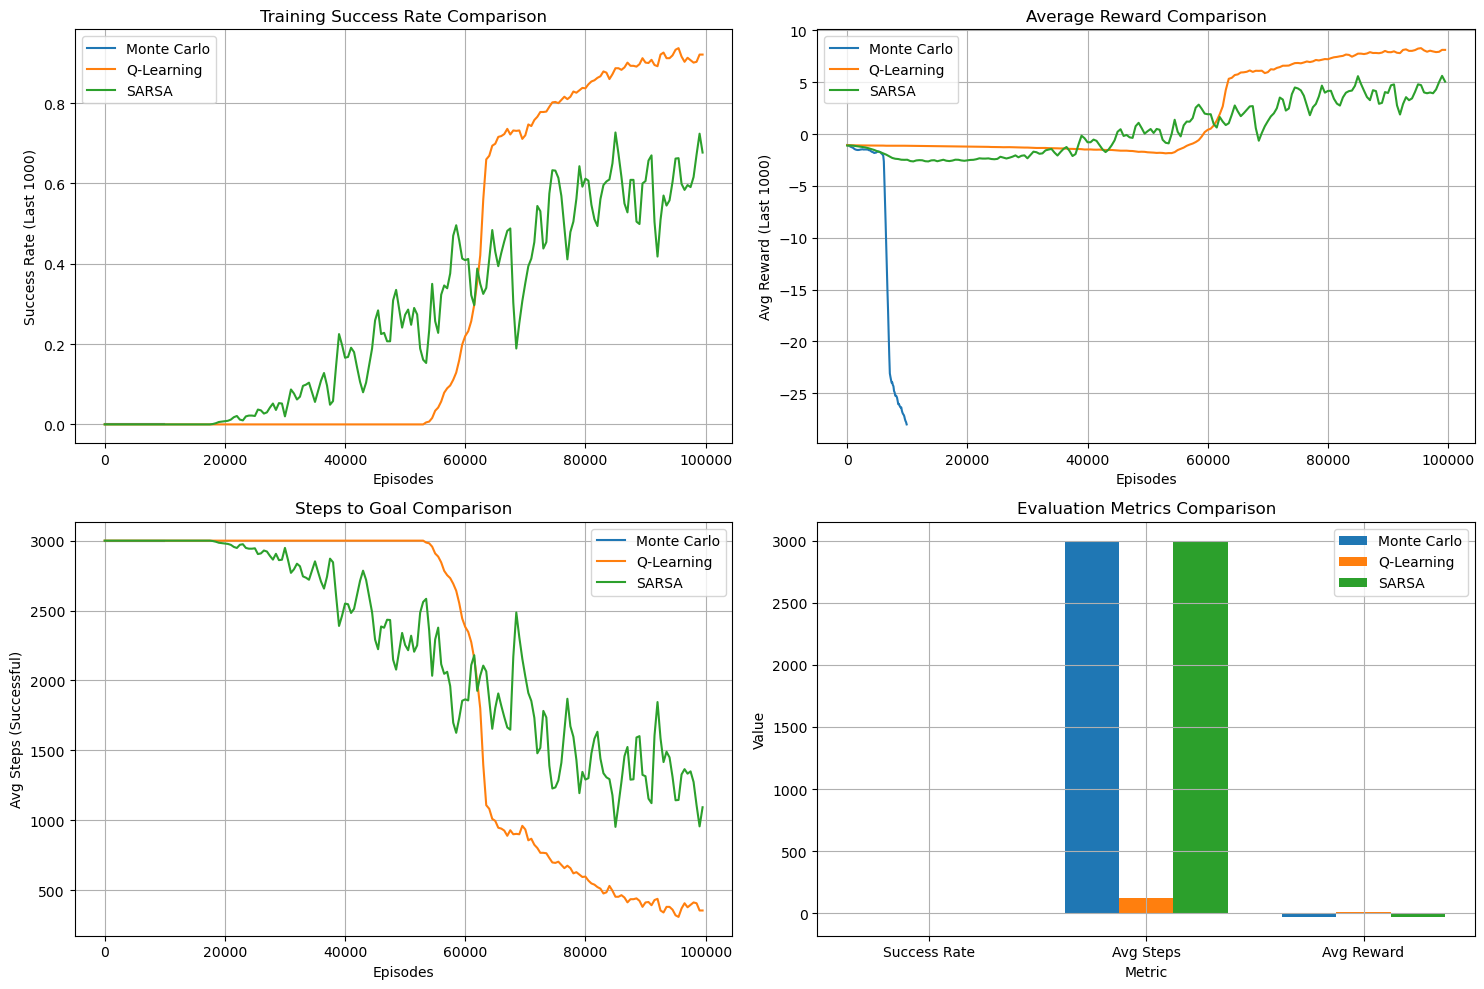

In [25]:
plt.figure(figsize=(15, 10))

# Success Rate Comparison
plt.subplot(2, 2, 1)
plt.plot(mc_metrics['episodes'], mc_metrics['success_rate'], label='Monte Carlo')
plt.plot(ql_metrics['episodes'], ql_metrics['success_rate'], label='Q-Learning')
plt.plot(sarsa_metrics['episodes'], sarsa_metrics['success_rate'], label='SARSA')
plt.title('Training Success Rate Comparison')
plt.xlabel('Episodes')
plt.ylabel('Success Rate (Last 1000)')
plt.legend()
plt.grid(True)

# Average Reward Comparison
plt.subplot(2, 2, 2)
plt.plot(mc_metrics['episodes'], mc_metrics['avg_reward'], label='Monte Carlo')
plt.plot(ql_metrics['episodes'], ql_metrics['avg_reward'], label='Q-Learning')
plt.plot(sarsa_metrics['episodes'], sarsa_metrics['avg_reward'], label='SARSA')
plt.title('Average Reward Comparison')
plt.xlabel('Episodes')
plt.ylabel('Avg Reward (Last 1000)')
plt.legend()
plt.grid(True)

# Steps to Goal Comparison
plt.subplot(2, 2, 3)
plt.plot(mc_metrics['episodes'], mc_metrics['steps_to_goal'], label='Monte Carlo')
plt.plot(ql_metrics['episodes'], ql_metrics['steps_to_goal'], label='Q-Learning')
plt.plot(sarsa_metrics['episodes'], sarsa_metrics['steps_to_goal'], label='SARSA')
plt.title('Steps to Goal Comparison')
plt.xlabel('Episodes')
plt.ylabel('Avg Steps (Successful)')
plt.legend()
plt.grid(True)

# Evaluation Metrics Comparison
plt.subplot(2, 2, 4)
metrics = ['Success Rate', 'Avg Steps', 'Avg Reward']
mc_values = [mc_success, mc_steps, mc_reward]
ql_values = [ql_success, ql_steps, ql_reward]
sarsa_values = [sarsa_success, sarsa_steps, sarsa_reward]

bar_width = 0.25
index = np.arange(len(metrics))

plt.bar(index, mc_values, bar_width, label='Monte Carlo')
plt.bar(index + bar_width, ql_values, bar_width, label='Q-Learning')
plt.bar(index + 2*bar_width, sarsa_values, bar_width, label='SARSA')

plt.title('Evaluation Metrics Comparison')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(index + bar_width, metrics)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("algorithm_comparison.png")
plt.show()

Metrics - 

In [27]:
print("\n=== FINAL RESULTS ===")
print(f"{'Metric':<15} {'Monte Carlo':<15} {'Q-Learning':<15} {'SARSA':<15}")
print(f"{'Avg Steps':<15} {mc_steps:<15.1f} {ql_steps:<15.1f} {sarsa_steps:<15.1f}")
print(f"{'Avg Reward':<15} {mc_reward:<15.3f} {ql_reward:<15.3f} {sarsa_reward:<15.3f}")


=== FINAL RESULTS ===
Metric          Monte Carlo     Q-Learning      SARSA          
Avg Steps       3000.0          126.0           3000.0         
Avg Reward      -28.690         8.971           -28.755        


Visualising policy - 

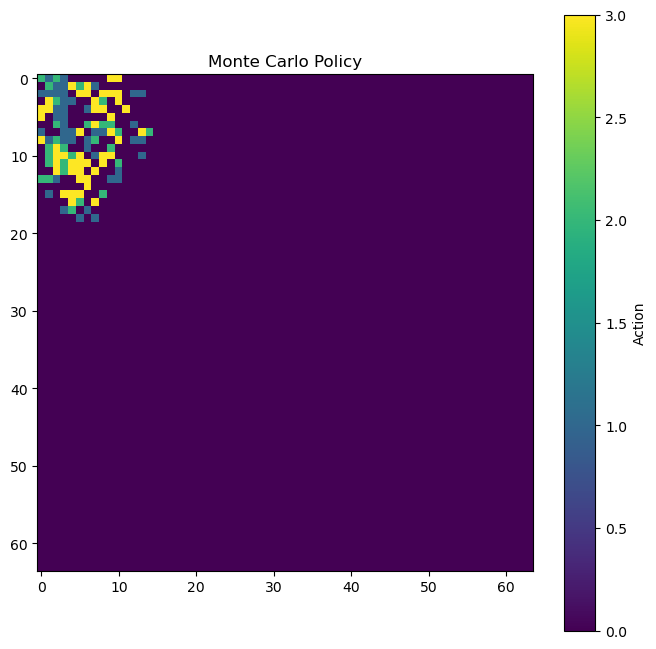

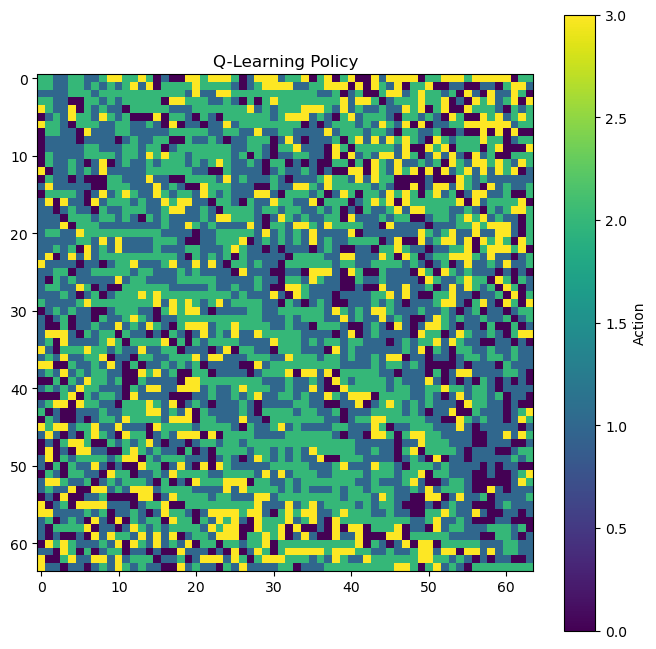

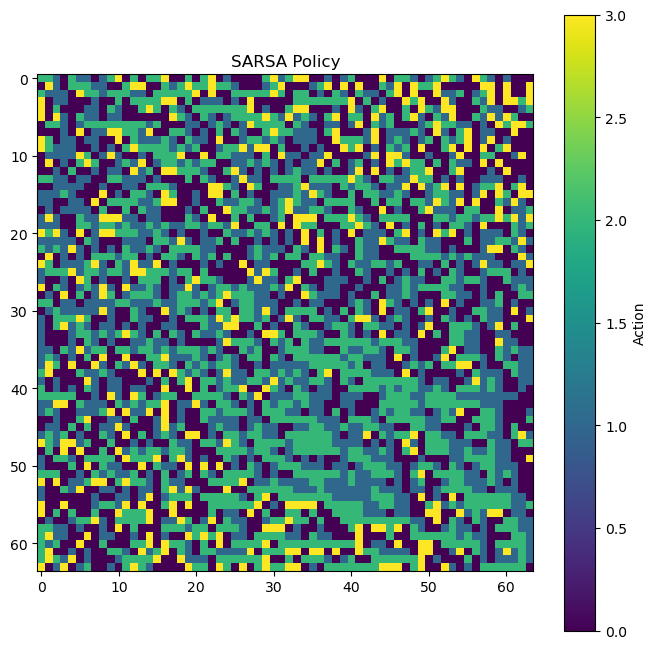

In [28]:
def visualize_policy(agent, title, env):
    policy = agent.get_policy().reshape((env.size, env.size))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(policy, cmap='viridis')
    plt.title(f"{title} Policy")
    plt.colorbar(label='Action')
    plt.clim(0, 3)
    plt.show()

visualize_policy(mc_agent, "Monte Carlo", env)
visualize_policy(ql_agent, "Q-Learning", env)
visualize_policy(sarsa_agent, "SARSA", env)


Summary -

Q-Learning Performed Best

    Off-policy advantage: Q-learning is off-policy, meaning it learns the value of the optimal policy while still exploring with a different behavior policy (e.g., epsilon-greedy). This helps it converge faster and more reliably to high-performing actions.

    Greedy bias: It always looks ahead using the maximum Q-value of the next state, which biases it toward optimal decisions.

    Better exploration-exploitation balance: With a decaying epsilon and adaptive learning rate, Q-learning can explore early and exploit well later, which led to a high success rate and average reward.

SARSA Was Moderate

    On-policy limitation: SARSA updates its Q-values based on the action it actually took, which may not always be optimal — especially in early training when exploration is high.

    Cautious learning: Because it incorporates the action chosen by the current (exploratory) policy, SARSA tends to be more conservative and safer, avoiding risky paths that could lead to holes.

    Result: This makes SARSA slightly slower to converge and results in fewer risky but high-reward behaviors, explaining its moderate success rate and average reward.

Monte Carlo Performed Worst

    Delayed updates: Monte Carlo only updates Q-values after the full episode ends, unlike Q-learning and SARSA which update per step. This leads to slower learning, especially in long or failed episodes.

    High variance: Returns calculated in MC can vary a lot depending on early steps in the episode, making learning less stable.

    Sparse reward issue: If the agent rarely reaches the goal early in training, MC has very little useful return data to work with, delaying progress.

    Result: Hence, Monte Carlo had a lower success rate, needed more steps, and accumulated less reward on average.

Conclusion - even when i reduced the map size to 64x64 from 100x100, Monte Carlo was no where near good results. Q learning performs the best followed by sarsa 